<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/SPY_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4071    0  4071    0     0   3232      0 --:--:--  0:00:01 --:--:--  3233
100  517k  100  517k    0     0   247k      0  0:00:02  0:00:02 --:--:-- 1862k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4083    0  4083    0     0   9205      0 --:--:-- --:--:-- --:--:--  9216
100  392k  100  392k    0     0   344k      0  0:00:01  0:00:01 --:--:--  628k


# Step 2: Download data and prepare main dataframe

In [2]:
import yfinance as yf

#Load dataset

# Download data for multiple tickers (SPY, DIA, QQQ, IWM, XLK)
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data without multi-index column names
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)

    # Rename columns to remove multi-index formatting and ticker name
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # Store the cleaned DataFrame in the dictionary
    dfs[ticker] = df

# Choose the main dataset for demonstration, SPY
data = dfs["SPY"].copy()

data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2012-01-03 00:00:00+00:00,101.091980,127.500000,128.380005,127.430000,127.760002,193697900
1,2012-01-04 00:00:00+00:00,101.250488,127.699997,127.809998,126.709999,127.199997,127186500
2,2012-01-05 00:00:00+00:00,101.520111,128.039993,128.229996,126.430000,127.010002,173895000
3,2012-01-06 00:00:00+00:00,101.258461,127.709999,128.220001,127.290001,128.199997,148050000
4,2012-01-09 00:00:00+00:00,101.504280,128.020004,128.179993,127.410004,128.000000,99530200


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3018 entries, 0 to 3017
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       3018 non-null   datetime64[ns, UTC]
 1   Adj Close  3018 non-null   float64            
 2   Close      3018 non-null   float64            
 3   High       3018 non-null   float64            
 4   Low        3018 non-null   float64            
 5   Open       3018 non-null   float64            
 6   Volume     3018 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 165.2 KB


#Step 3: Adding features (technical indicators)

In [4]:
# Calculate RSI
data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
data['MACD'], data['MACD_signal'], data['MACD_diff'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
data['bb_bbm'], data['bb_bbh'], data['bb_bbl'] = talib.BBANDS(data['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Calculate Keltner Channel (KC)
data['EMA_KC'] = talib.EMA(data['Adj Close'], timeperiod=20)
data['KC_upper'] = data['EMA_KC'] + (data['ATR'] * 1.5)
data['KC_lower'] = data['EMA_KC'] - (data['ATR'] * 1.5)
data['KC'] = (data['Adj Close'] - data['KC_upper']) / data['Adj Close']
data.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

# Calculate Donchian Channel (DC)
data['DC_upper'] = data['High'].rolling(window=20).max()
data['DC_lower'] = data['Low'].rolling(window=20).min()
data['DC_middle'] = (data['DC_upper'] + data['DC_lower']) / 2

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])

# Calculate Chaikin Money Flow (CMF)
cmf_period = 20
data['Money_Flow_Multiplier'] = ((data['Adj Close'] - data['Low']) - (data['High'] - data['Adj Close'])) / (data['High'] - data['Low'])
data['Money_Flow_Volume'] = data['Money_Flow_Multiplier'] * data['Volume']
data['CMF'] = data['Money_Flow_Volume'].rolling(window=cmf_period).sum() / data['Volume'].rolling(window=cmf_period).sum()
data.drop(columns=['Money_Flow_Multiplier', 'Money_Flow_Volume'], inplace=True)

# Calculate the Stochastic Oscillator
data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Adj Close'],
                                               fastk_period=14,  # The %K period
                                               slowk_period=3,   # The %K slowing period
                                               slowk_matype=0,   # Moving average type for %K (0 = SMA)
                                               slowd_period=3,   # The %D period
                                               slowd_matype=0)   # Moving average type for %D (0 = SMA)

# Calculate the Average Directional Index (ADX)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Number of lag days to create
lags = 20

# List of features to create lag features (exlcude "Adj Close")
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                   'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC','DC_upper', 'DC_lower',
                   'DC_middle','OBV','CMF','stoch_k','stoch_d','ADX']

# Function to create lagged features
def create_lagged_features(df, lags, columns):
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Apply lagged features
data = create_lagged_features(data, lags, features_to_lag)
data.dropna(inplace=True)

# Display the data to see the added lagged columns
data.head()

<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

,Date,Adj Close,Close,High,Low,Open,Volume,RSI,MACD,MACD_signal,...,ADX_lag_11,ADX_lag_12,ADX_lag_13,ADX_lag_14,ADX_lag_15,ADX_lag_16,ADX_lag_17,ADX_lag_18,ADX_lag_19,ADX_lag_20
53,2012-03-20 00:00:00+00:00,111.839790,140.440002,140.610001,139.639999,140.050003,121729700,71.356372,1.443677,1.252668,...,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821,47.324620,47.394768,47.758703,47.692382
54,2012-03-21 00:00:00+00:00,111.656639,140.210007,140.649994,139.919998,140.520004,122388400,69.496856,1.432621,1.288658,...,39.420999,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821,47.324620,47.394768,47.758703
55,2012-03-22 00:00:00+00:00,110.852287,139.199997,139.550003,138.740005,139.179993,135216700,61.871209,1.343468,1.299620,...,36.721962,39.420999,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821,47.324620,47.394768
56,2012-03-23 00:00:00+00:00,111.210663,139.649994,139.809998,138.550003,139.320007,120521000,63.778242,1.286897,1.297076,...,35.165553,36.721962,39.420999,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821,47.324620
57,2012-03-26 00:00:00+00:00,112.771492,141.610001,141.610001,140.600006,140.649994,120164000,70.660865,1.352420,1.308145,...,34.149188,35.165553,36.721962,39.420999,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821


#Step 4: Data Cleaning

In [5]:
#Drop Non-Lagged Technical Indicators

# Define the target column
target_column = 'Adj Close'

# List of non-lagged technical indicators to drop
non_lagged_technical_indicators = [
    'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh', 'bb_bbl',
    'KC', 'DC_upper', 'DC_lower', 'DC_middle', 'OBV', 'CMF', 'ADX', 'stoch_k', 'stoch_d'
]

# Drop non-lagged columns and other unwanted columns
columns_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume'] + non_lagged_technical_indicators
data = data.drop(columns=columns_to_drop, errors='ignore')

#Step 5: Feature Importance

In [7]:
# Train RandomForestRegressor to determine feature importance
X = data.drop(columns=['Adj Close','Date'])
y = data['Adj Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
important_features = [X.columns[i] for i in indices if importances[i] > 0.01]

#Step 6: Split data

In [9]:
# Convert 'Date' to datetime and set as index (if not already done)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Now split the data into train, validation, and test sets
train_data = data[:'2021-12-31']
val_data = data['2022-01-01':'2022-12-31']
test_data = data['2023-01-01':]

# Verify splits by printing the outputs (optional step to confirm the splits are correct)
print("Training Data Sample:", train_data.head())
print("Validation Data Sample:", val_data.head())
print("Testing Data Sample:", test_data.head())

# Prepare features and targets using only important features
X_train = train_data[important_features]
y_train = train_data['Adj Close']
X_val = val_data[important_features]
y_val = val_data['Adj Close']
X_test = test_data[important_features]
y_test = test_data['Adj Close']

Training Data Sample:                             Adj Close  Volume_lag_1  Volume_lag_2  \
Date                                                                
2012-03-20 00:00:00+00:00  111.839790   125291100.0   152893500.0   
2012-03-21 00:00:00+00:00  111.656639   121729700.0   125291100.0   
2012-03-22 00:00:00+00:00  110.852287   122388400.0   121729700.0   
2012-03-23 00:00:00+00:00  111.210663   135216700.0   122388400.0   
2012-03-26 00:00:00+00:00  112.771492   120521000.0   135216700.0   

                           Volume_lag_3  Volume_lag_4  Volume_lag_5  \
Date                                                                  
2012-03-20 00:00:00+00:00   165118500.0   145163600.0   184090500.0   
2012-03-21 00:00:00+00:00   152893500.0   165118500.0   145163600.0   
2012-03-22 00:00:00+00:00   125291100.0   152893500.0   165118500.0   
2012-03-23 00:00:00+00:00   121729700.0   125291100.0   152893500.0   
2012-03-26 00:00:00+00:00   122388400.0   121729700.0   125291100.0 

#Step 7: Scale the data

In [12]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

#Step 8: Build and Train the LSTM Model

In [13]:
# Build and train LSTM using important features
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, len(important_features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled.reshape((-1, 1, len(important_features))), y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled.reshape((-1, 1, len(important_features))), y_val_scaled))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0726 - val_loss: 0.0036
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0020

#Step 9: Make Predictions and Evaluate

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
# Make predictions and evaluate the model
predictions = model.predict(X_test_scaled.reshape((-1, 1, len(important_features))))
predictions = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(actual, predictions))
r2 = r2_score(actual, predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


RMSE: 13.759284305366469, R²: 0.6730853605960149


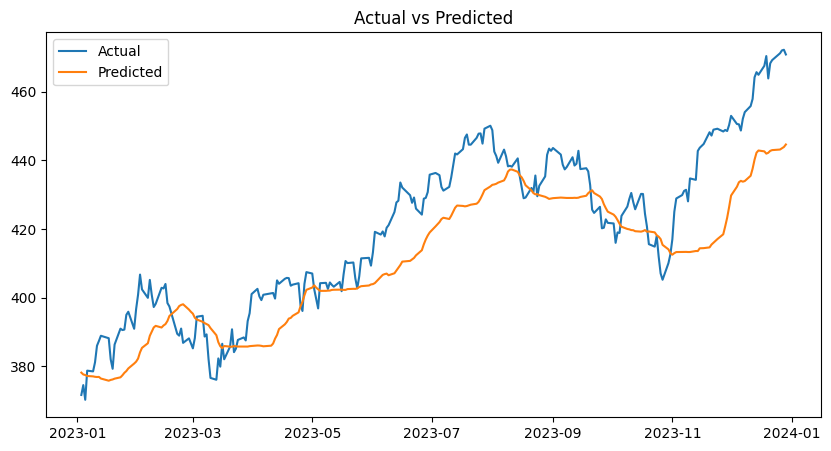

In [16]:
# Print performance metrics and plot results
print(f"RMSE: {rmse}, R²: {r2}")
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, actual, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()